# Analysis - preprocessing 


## 01/10/2020
In this section the train audio data is loaded and preprocessed, to explore options for feature extraction. 


import pydub

from os import listdir
from os.path import isfile, join
mypath = "./data/youtube"
pydub.AudioSegment.ffmpeg = r"C:\\Users\\Andy Cai\\Documents\\Cambridge\\Year 4\\project\\Python\\ffmpeg.exe"
print(pydub.AudioSegment.ffmpeg)
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for file in onlyfiles:
    print (file)
    if "mp3" in file:
    
        src = join( r"C:\Users\Andy Cai\Documents\Cambridge\Year 4\project\Python\data\youtube" , file)
        print(src)
        mysound = pydub.AudioSegment.from_mp3(src)
        dst = "./data/youtube/wav/"+ file[:-4]+".wav"
        mysound.export(dst,format ="wav")



## librosa 

Here, we use the librosa library to process the wav files. The files are loaded into an array x.

In [16]:
#loading a piece of data and visualising 
import numpy as np
import librosa 
audio_file = './data/youtube/wav/7_cropped.wav'
x = librosa.load(audio_file, sr=None)


## Matplotlib visualisation 05/10/2020


The array x[0] contains the amplitude of the sound signal sampled at 22kHz. x[1] contains the sampling rate. The waveform can be observed using matplotlib. Here, the waveform is shown for time = 10s -> 20s. 

10.989342403628118


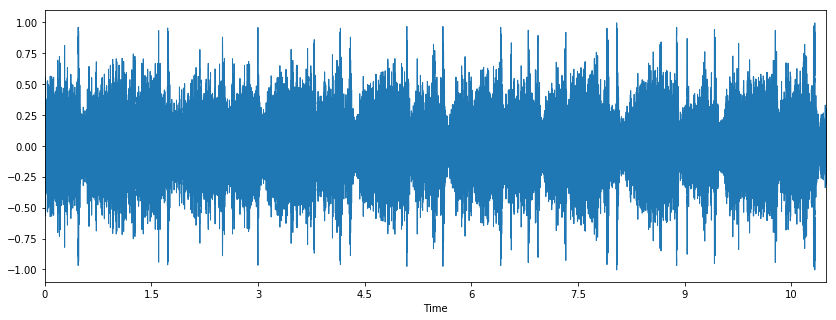

In [21]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import librosa.display 
plt.figure(figsize = (14,5))

sr = x[1]
start = 0
finish = len(x[0])
librosa.display.waveplot(x[0][start:finish],sr)
print(finish/sr)
# we want the sample rat

# listening to the audio  06/10/2020

Very little can be observed in the time domain, so the audio is displayed and listened to. 

In [3]:
import IPython.display as ipd
ipd.Audio(x[0][start:finish],rate = sr)

def listen(x,sr = 22050):
    return(ipd.Audio(x,rate = sr))
ipd.Audio(x[0][start:finish],rate = sr)


In [4]:
ipd.Audio(x[0][int(start*1.5):int(finish*1.5)],rate = 22050)

# Spectrogram  08/10/2020

To observe how the frequency components varies with time, a fourier transform can be done on the data to observe the energies of differnt frequencies, which gives an insight into what kind of features we might want to extract. 


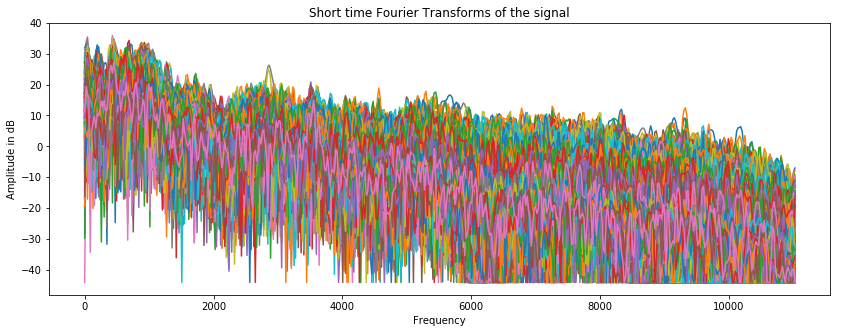

In [5]:
ft = librosa.stft(x[0][start:finish],n_fft=1024)
ftdb = librosa.amplitude_to_db(abs(ft))
plt.figure(figsize=(14,5))
bins = librosa.fft_frequencies(sr=22050, n_fft = 1024)
plt.plot(bins,ftdb)
plt.ylabel("Amplitude in dB")
plt.xlabel("Frequency")
plt.title("Short time Fourier Transforms of the signal")
plt.show()



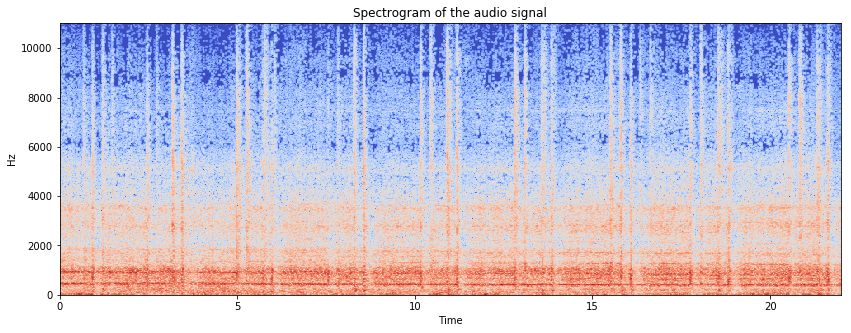

In [6]:
fig, ax = plt.subplots(figsize=(14,5))

librosa.display.specshow(ftdb,sr=sr,x_axis='time',y_axis='hz',ax=ax)
ax.set_title("Spectrogram of the audio signal")

def plt_logspec(x,sr=22050,sc = "log"):
    ft = librosa.stft(x)
    ftdb = librosa.amplitude_to_db(abs(ft))
    plt.figure(figsize=(14,5))
    librosa.display.specshow(ftdb,sr=sr,x_axis='time',y_axis=sc)
    
    

## Axis scaling  08/10/2020
The plot above has the y - axis shown in hz, which may nbot offer the best insight as much of the signature may be contained in the lower frequency region. The next step would either be to down sample to focus on the lower frequencies, or to change the scaling of the axis to a logarithmic one. Here the log-frequency spectrogram is plotted. In this case, it is observed that this made the high frequency features less prominent, however it shows a clear resonance behaviour for the signal at 512 and 1024 Hz. 


<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

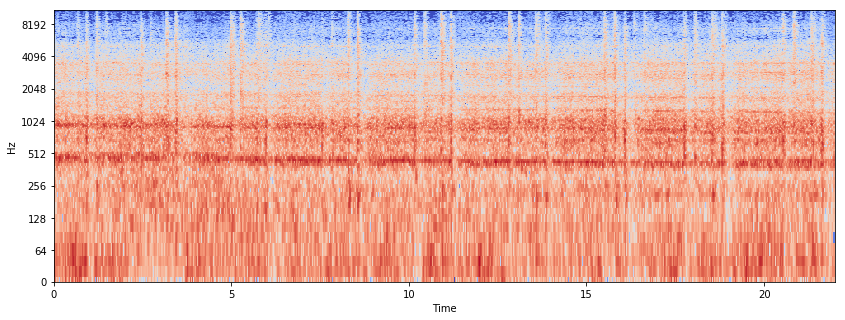

In [7]:
plt.figure(figsize=(14,5))
librosa.display.specshow(ftdb,sr=sr,x_axis='time',y_axis='log')
plt.colorbar

# Preprocessing   08/10/2020 
## Normalisation 
All the audio clips have been collected from different sources, with differnt recording equipment and camera sense. Because of the unlabelled nature of the data, some kind of clustering may be considered, as a result amplitude normalisation is a necessary step to prevent the model from being affected by absolute amplitude. 

This can be done using the sklearn library.

In [8]:
import sklearn 

def normalise(x,axis=0):
    return sklearn.preprocessing.minmax_scale(x,feature_range=(-1,1))
def get_data(x,start,finish):
    return normalise(x[start:finish])

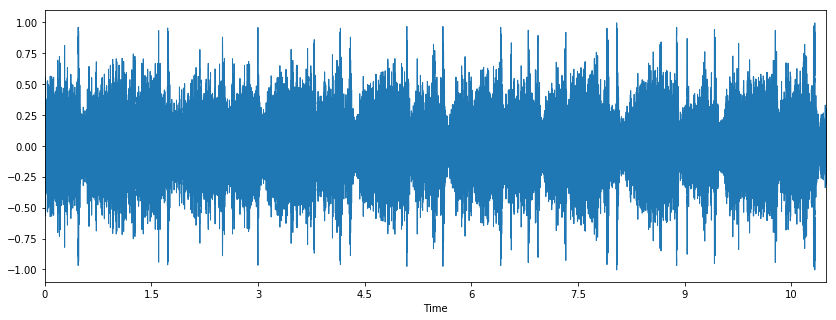

In [9]:
og = x[0][start:finish]

normalised = normalise(og)
plt.figure(figsize=(14,5))

librosa.display.waveplot(og,sr)


 09/10/2020 The response is not obvious with just the time domain representatin, need to view frequency information as welll to get more about what the normalisation is doing

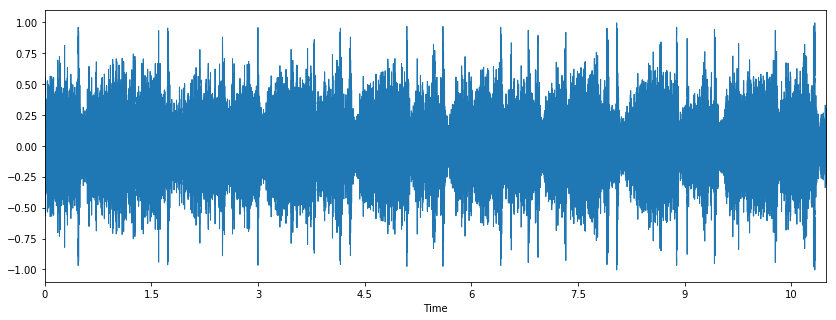

In [10]:
plt.figure(figsize=(14,5))
librosa.display.waveplot(normalised,sr)


In [11]:
ipd.Audio(normalised,rate = 22050)

##  09/10/2020
The normalised audio is listened to, difficult to tell if contrast and mean has changed, need to plot the spectrogram and have a look that way. 

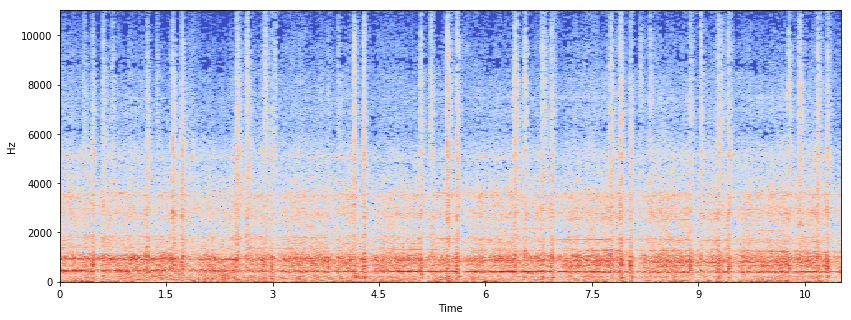

In [12]:
plt_logspec(normalised, sc = 'hz')

# Noise Reduction  17/10/2020

In order to extract any anomaly from the sound recorded from the train, we must remove the constant operation noise from the waveform. This operation noise could be from the normal wheel-track interraction on flat track, or it could be from wind noise. The benefit of collecting data on the train is that the noise should be fairly constant, and using a noise cancelling algorithm, we can effectively remove the environmental noise. The ideal scenario after this stage is to be able to have clean sound for features such as rail joints, switches and hopefully defects. Then, it can be treated potentially as a speech recognition roblem.

Here we use the spectral gating algorithm to remove noise. To implement this, a library called noise reduce is used. The noise spectrogram is firstly obtained by definining a noisy part of the signal, then a threshold is set and the filter is applied to the data. The result is a data profile with much of the noise removed. 


(242315,)


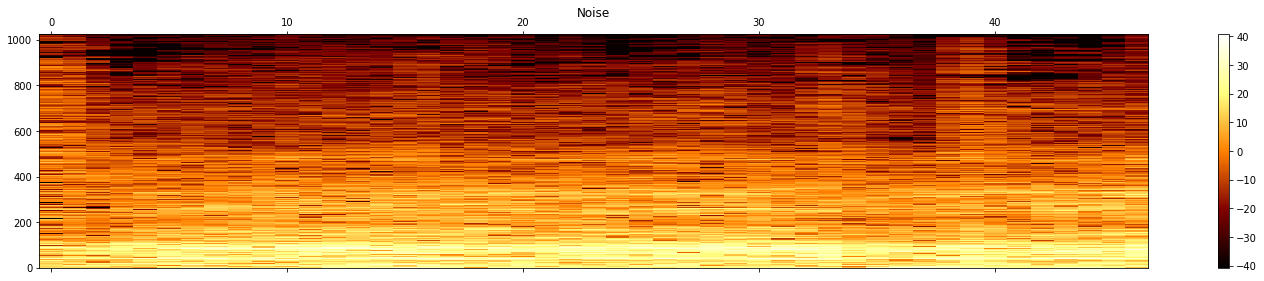

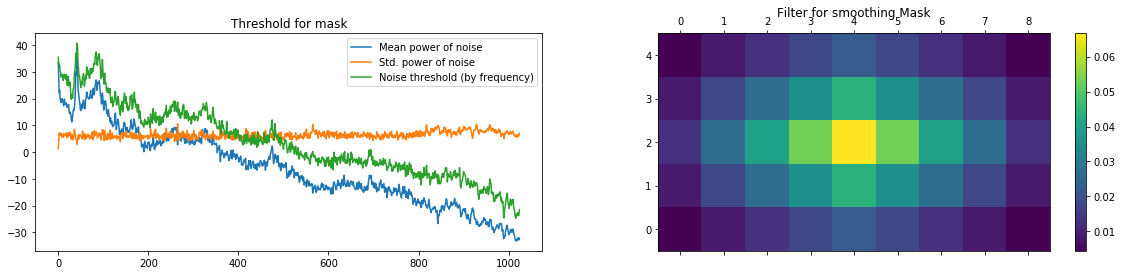

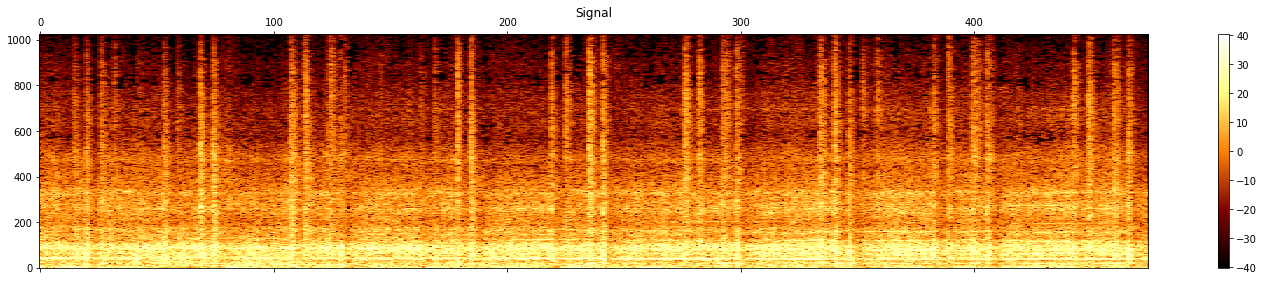

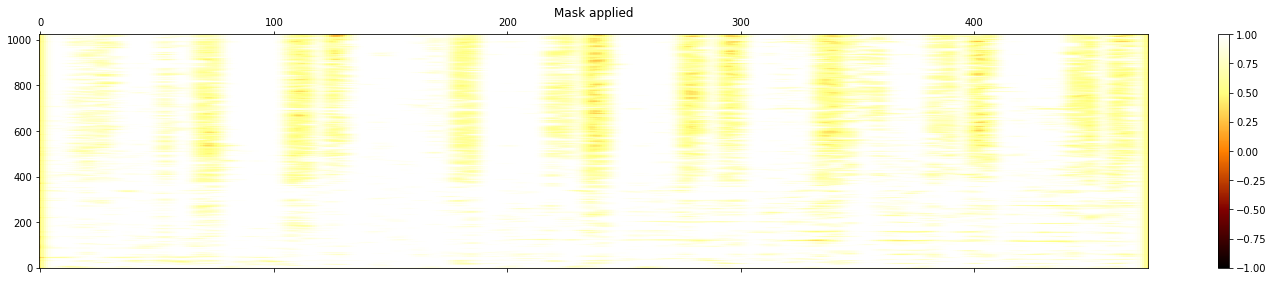

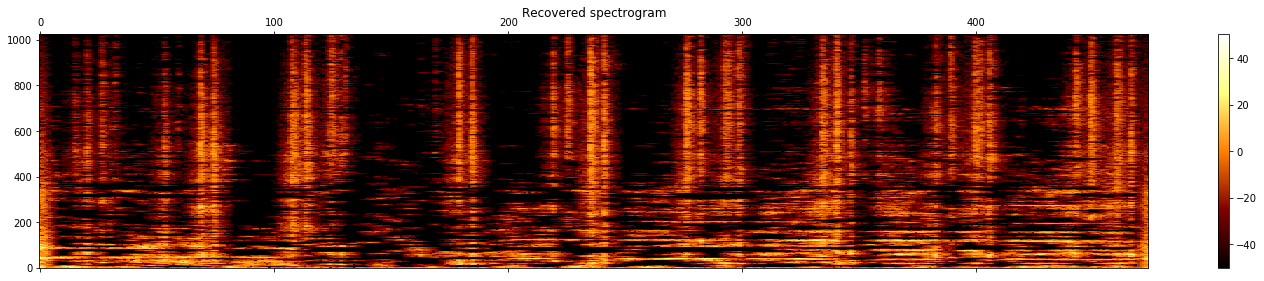

In [22]:
import noisereduce 
start = 3*sr
print(np.shape(x[0]))
data = get_data(x[0],0, len(x[0]))
noisy_part = get_data(x[0],start+int(0.02*sr),start+int(1.1*sr))
reduced = noisereduce.reduce_noise(audio_clip = data, noise_clip = noisy_part, verbose = True)

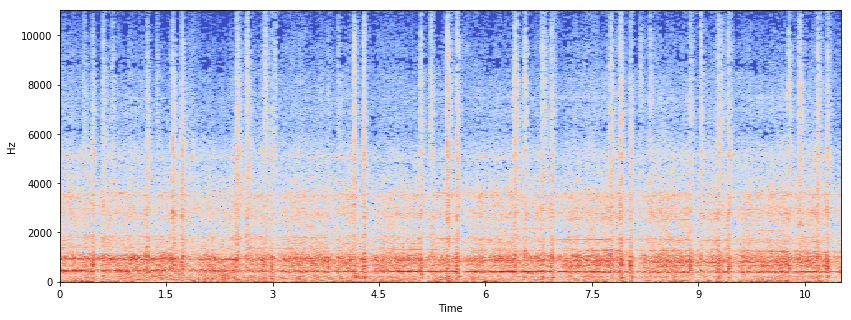

In [23]:
plt_logspec(data,sc='hz')


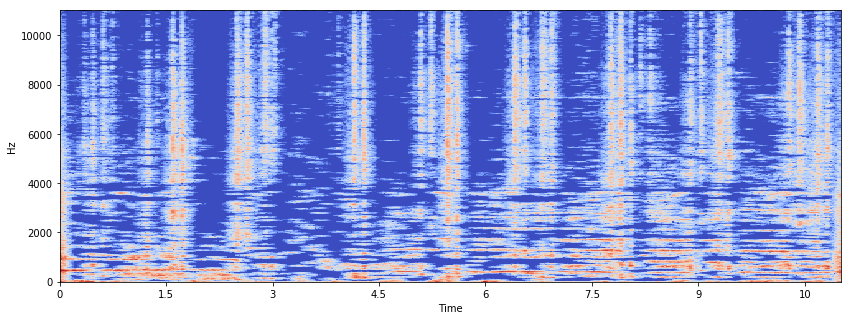

In [26]:
plt_logspec(reduced, sc= "hz")

In [24]:
listen(reduced)

In [25]:
listen(og)

## Energy of signal  24/10/2020

part of exploring the signal, calculate the energy of the signal and plot them on the same graph as the spectrogram. if there is an interesting response like a peak then this can potentially be used. 

### Dividing into 10ms frames

first everythign needs to be windowedl, this is done by slicing the spectrogram

In [28]:
frames = []
frame_length = 0.01  #this is 0.01 second 

data = get_data(x[0],0, len(x[0]))
noisy_part = get_data(x[0],start+int(0.02*sr),start+int(1.1*sr))
reduced = noisereduce.reduce_noise(audio_clip = data, noise_clip = noisy_part)
for i in range(int(len(data)/(sr*frame_length))-1):
    start_pos = int(i*frame_length*sr)
    finish_pos = int((i+1)*frame_length*sr)
    
    frames.append(data[start_pos:finish_pos])
print(len(frames))    

1097


In [29]:
def split_audio(x,dur=0.01, sr = 22050):
    frame_list =[]
    ft_list=[]
    for i in range(int(len(x)/(sr*dur))-1):
        start_pos = int(i*dur*sr)
        finish_pos = int((i+1)*frame_length*sr)
        frame=x[start_pos:finish_pos]
        frame_list.append(frame)
        ft_list.append(np.mean(librosa.amplitude_to_db(abs(librosa.stft(frame))),axis=1))
    print("success, %d samples have been generated" % len(frame_list))
    return (frame_list,ft_list)

1097


c:\users\andy cai\appdata\local\programs\python\python36\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=220
  n_fft, y.shape[-1]


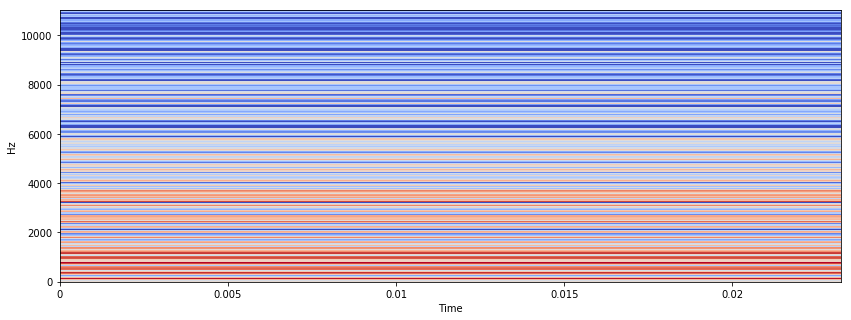

In [30]:
plt_logspec(frames[10], sc = 'hz')
t_list = np.linspace(0,len(frames),len(frames))*frame_length
print(len(t_list))

c:\users\andy cai\appdata\local\programs\python\python36\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=221
  n_fft, y.shape[-1]


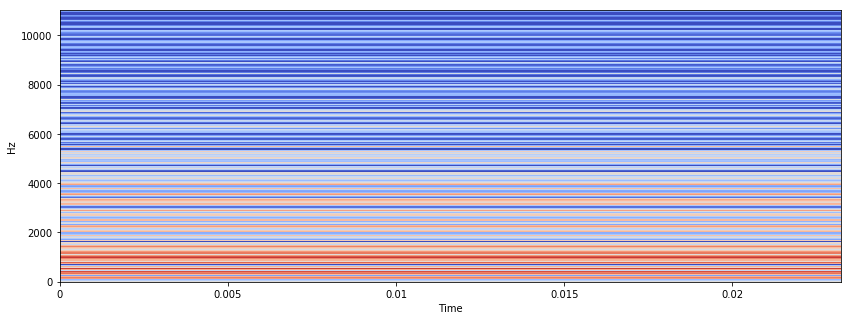

In [31]:
plt_logspec(frames[3], sc = 'hz')

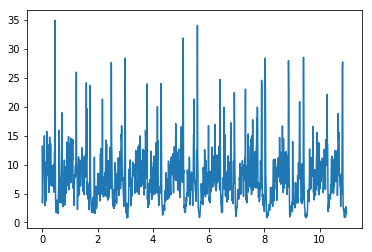

In [32]:
frame_energies = []
for f in frames:
    frame_energies.append(np.dot(f,f))
plt.plot(t_list,frame_energies)


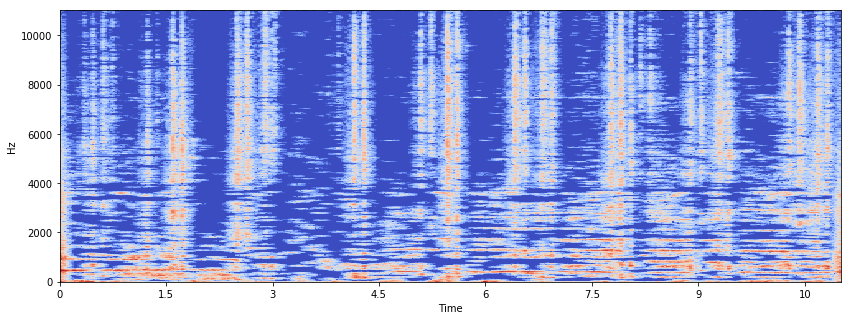

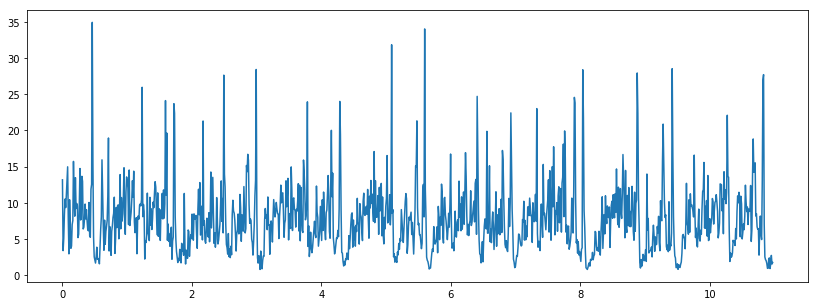

In [33]:
ft = librosa.stft(reduced)
ftdb = librosa.amplitude_to_db(abs(ft))
myfig=plt.figure(figsize=(14,5))
librosa.display.specshow(ftdb,sr=sr,x_axis='time',y_axis='hz')
hold = True 
plt.figure(figsize = (14,5))
plt.plot(t_list,frame_energies)
plt.show()

In [34]:
frames_ft = []
for frame in frames:
    frames_ft.append(np.mean(abs(librosa.stft(frame)),axis=1))


c:\users\andy cai\appdata\local\programs\python\python36\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=220
  n_fft, y.shape[-1]
c:\users\andy cai\appdata\local\programs\python\python36\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=221
  n_fft, y.shape[-1]


In [35]:
print([max(frames_ft[0]),min(frames_ft[0])])


[116.06999, 2.9629096e-05]


## Let's Try PCA!  30/10/2020

This is the first proper technique. in this initial implementation it is first used on columns of the spectrogram, so that this is still only currently acting on the frequency domain only. Latter should apply this technique to the time frequency domain and it should yield better results. 

In [36]:
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
print(len(frames_ft[0]))

1025


In [37]:
X_std = StandardScaler().fit_transform(frames_ft)
print(np.shape(X_std))

(1097, 1025)


In [38]:
pca = PCA(n_components=30)
mypca = pca.fit_transform(X_std)


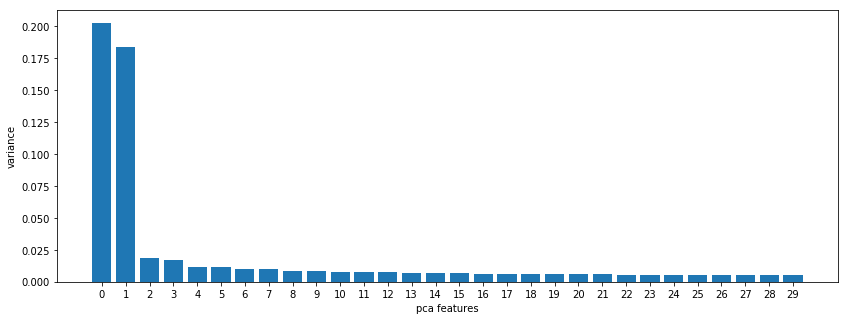

In [39]:
features = range(pca.n_components_)
plt.figure(figsize=(14,5))
plt.bar(features,pca.explained_variance_ratio_)
plt.xlabel('pca features')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

## thoughts 30/10/2020

This is a very weird response, it seems to be perfectly separating all the samples in a way which is quite useless. there are two principle components which are very strong compared to the rest. Worth investigating what this means. 

30


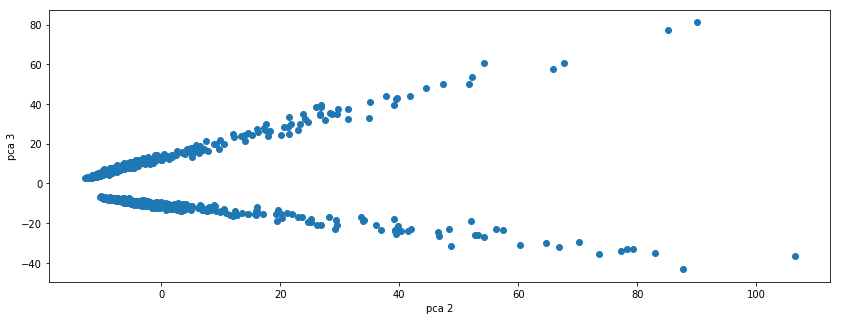

In [40]:
plt.figure(figsize=(14,5))
PCA_components = pd.DataFrame(mypca)
plt.scatter(PCA_components[0],PCA_components[1])
print(len(mypca[0]))
plt.xlabel('pca 2')
plt.ylabel('pca 3')
plt.show()

### seeing where the switch sounds lie

In [ ]:
df = PCA_components[0:1]
bottom = df[0]>0